# Azure Data University: mlos_bench SQLite data analysis (Student's workbook)

In this notebook, we look at the data from the `mlos_bench` experiment we run in class to find a better SQLite configuration.

### 1. Data collection

Before using this notebook, run the following commands in the integrated terminal of this codespace:

```sh
conda activate mlos

mlos_bench --config config/cli/local-sqlite-opt.jsonc \
           --globals config/experiments/sqlite-sync-journal-pagesize-caching-experiment.jsonc \
           --max-iterations 100
```

> See Also: [README.md](./README.md) for further instructions.

After letting it run for a few trials (it should take 10 to 15 minutes), we can start analyzing the autotuning data produced by the `mlos_bench` framework.

### 2. Import packages

We will use a few common third-party libraries for data analysis. If you have never used them before, don't worry! This workshop would be a great opportunity for you to learn the basics. Here are some useful resources that you might want to open is a separate tab to keep as a reference during this class.
* [Pandas](https://pandas.pydata.org) - A package to work with tabular data in Python.
* [Matplotlib](https://matplotlib.org) - Most popular Python plotting library, powerful, but somewhat low-level by modern standards.
* [Seaborn](https://seaborn.pydata.org) - High-level data visualization package on top of Matplotlib.

All these packages come pre-installed with Python Anaconda distribution.

In [1]:
import pandas
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Cosmetic: Suppress some annoying warnings from third-party data visualization packages
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

We use `mlos_bench` Storage API to access the data that our framework has collected in the experiment.

In [3]:
# Import mlos_bench Storage API to access the experimental data.
from mlos_bench.storage import from_config

### 3. Connect to the DB using existing mlos_bench configs

We reuse the existing mlos_bench framework configuration file that contains the DB connection parameters. This way we make sure to connect to the same database that our framework uses to store the experimental data.

In [4]:
storage = from_config(config_file="storage/sqlite.jsonc")

### 4. Load the data for our experiment

At the top level, Storage API has a single property, `.experiments` that returns a Python `dict` of key/value pairs of Experiment ID and Experiment Data.

In [5]:
storage.experiments

{'mysql-innodb-bseries-v346-vmcontrol': Experiment :: mysql-innodb-bseries-v346-vmcontrol: 'Azure MySQL+Sysbench Root',
 'mysql-innodb-buf': Experiment :: mysql-innodb-buf: 'Azure MySQL+Sysbench Root',
 'mysql-innodb-explore-D2S': Experiment :: mysql-innodb-explore-D2S: 'Azure MySQL+Sysbench Root',
 'sqlite-sync-journal-pagesize-caching-experiment': Experiment :: sqlite-sync-journal-pagesize-caching-experiment: 'sqlite-local-benchbase'}

You should see a record for our experiment in the DB. Let's look at the data associated with it.

In [6]:
experiment_id = "sqlite-sync-journal-pagesize-caching-experiment"  # "sqlite-opt-demo"

### 5. Get all data for one experiment

In [7]:
exp = storage.experiments[experiment_id]

Main method that combines the information about each trial along with the trial configuration parameters and its results, is the property `.results`. It conveniently returns all data about the experiment is a single Pandas DataFrame.

In [8]:
df = exp.results

In [9]:
# TODO: Print the first 10 records of the DataFrame here

Each record of the DataFrame has the information about the trial, e.g., its timestamp and status, along with the configuration parameters (columns prefixed with `config.`) and the benchmark results (columns prefixed with `result.`). Let's look at the first record to see all these fields.

In [10]:
# TODO: Print a single record of the `df` DataFrame

### 6. Plot the results

Let's look at some configuration parameters and benchmark metrics we have in the DataFrame. Here are the DataFrame columns that we suggest:

In [11]:
# Categorical tunable to consider:
CATEGORY = "config.synchronous"

# A system resource metric to analyze.
METRIC = "result.File system outputs"

# Which performance metric to plot on the Y-axis.
SCORE = "result.90th Percentile Latency (microseconds)"

#### 6.1. Plot the behavior of the optimizer

First, let's see the benchmark results on each iteration.

* Build a scatterplot with trial number `trial_id` on X axis and the `SCORE` column on Y.
> You can easily do that with the [`sns.scatterplot()`](https://seaborn.pydata.org/generated/seaborn.scatterplot.html) function from [Seaborn](https://seaborn.pydata.org)
* On the same plot, add a line showing the best (i.e., minimal) score we have so far on each iteration.
> You can use [Pandas](https://pandas.pydata.org) method [`.cummin()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.cummin.html) to get a cumulative minimum of the column.
> Use [Seaborn](https://seaborn.pydata.org) function [`sns.lineplot()`](https://seaborn.pydata.org/generated/seaborn.lineplot.html) to visualize the results.

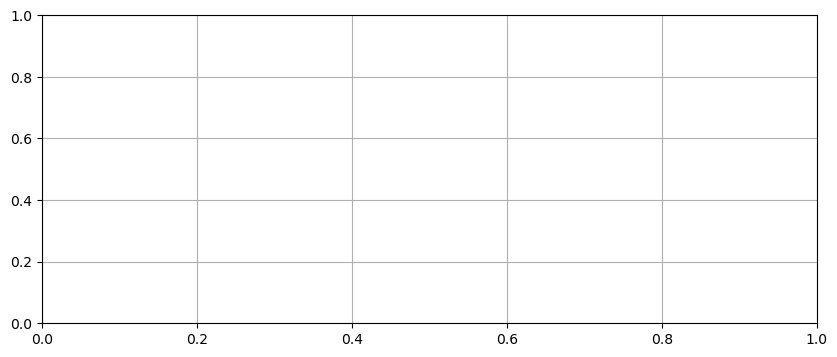

In [12]:
plt.rcParams["figure.figsize"] = (10, 4)  # Set the picture size to some reasonable values

# TODO: 1. Build a scatterplot with trial number trial_id on X axis and the SCORE column on Y.
# `sns.scatterplot()` is one function to do it.

# TODO: 2. Add a line showing the best (i.e., minimal) score we have so far on each iteration.
# You may want to use Pandas `.cummin()` method and `sns.lineplot()` from Seaborn.

# HINT: use plt.yscale('log') if the Y axis data it too spread out.

# HINT: Use plt.xlabel and plt.ylabel to give some nice human-readable names to each axis of the plot.

plt.grid()
plt.show()

We see that the optimizer finds a good configuration in about 10 interations. After that, it oscillates between exploring some remote areas of the configuration space (and getting some pretty bad banchmarking results) and exploiting the neighborhoods of the well-performing configurations, further improving the results.

#### 6.2. Plot the results of one metric vs. another for some tunable

The intent is to explore parameter importance and impact on different metrics (both application performance and system resource usage).

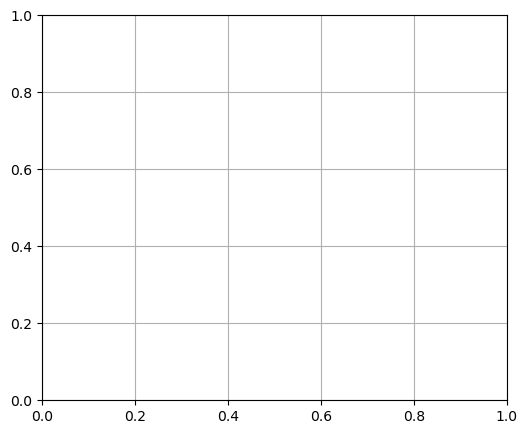

In [13]:
plt.rcParams["figure.figsize"] = (6, 5)  # Set the picture size to some reasonable values

# TODO: 1. Build another scatterplot to plot the `METRIC` against the `SCORE`.

# TODO: 2. add `hue=CATEGORY` parameter to visualize the additional configuration parameter.
# (Which is "config.synchronous", as we've defined in p. 6).

plt.grid()
plt.show()

The results are here, but the outliers make it really difficult to understand what's going on. Let's switch to the log scale and see if that helps.

#### 6.3. Plot on log scale

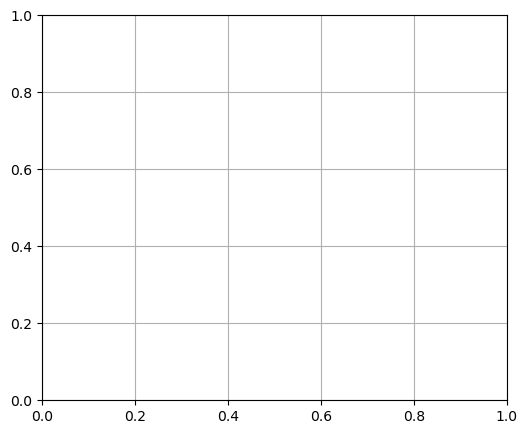

In [14]:
plt.rcParams["figure.figsize"] = (6, 5)  # Set the picture size to some reasonable values

# TODO: Use the same code as above, but add `plt.xscale("log")` and/or `plt.yscale("log")`, like we did in 6.1.

plt.grid()
plt.show()

 Now you should see - if you have enough data - that setting `synchronous=off` seems to improve the latency a lot. Apparently, the optimizer had also noticed that and focused on exploring a particular area of the configuration space. Let's switch back to the linear scale and zoom in to that region.

#### 6.4. Zoom in

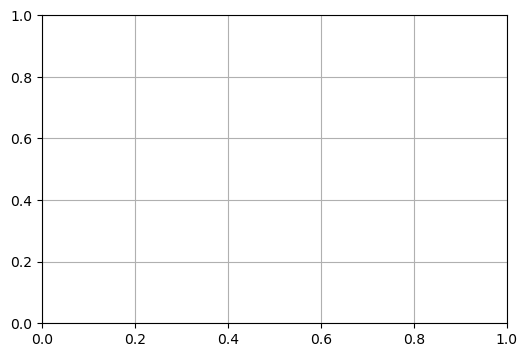

In [15]:
plt.rcParams["figure.figsize"] = (6, 4)

# TODO: Use the same code as above, but switch back to the linear scale, and use
# Matplotlib `plt.xlim()` and `plt.ylim()` functions to limit the area being visualized.

plt.grid()
plt.show()

> **NOTE:** If you have your experiment still running in the background, now is a good time to re-run all the cells above and reload the data, so you can have a few more data points in your `df` DataFrame.

You should see that the latency seems to be minimal when the configuration parameter `synchronous` is set to `off` and when the metric `File system outputs` is in range of 100..300K. Let's focus on that subset of data and see what other configuration settings get us there.

#### 6.5. Look at other configuration parameters

In [16]:
# TODO: Make sure that the range for `METRIC` and value of `CATEGORY` are correct.
# Feel free to add or drop the filtering criteria in the statement below to focus on the right subset of the data.

df_lim = df[(df[CATEGORY] == "off") & (df[METRIC] > 100000) & (df[METRIC] < 300000)]

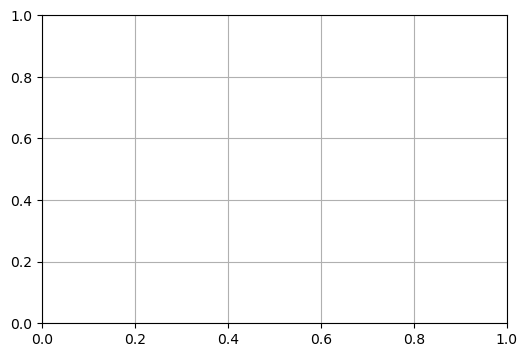

In [17]:
plt.rcParams["figure.figsize"] = (6, 4)

# TODO: Copy the code from our previous plot and build a scatterplot of `df_lim` using different column names
# for `x` and `hue` parameters. # E.g., see how `config.cache_size` and `config.journal_mode` configuration
# parameters impact the query latency.

plt.grid()
plt.show()

Again, we see that setting `journal_mode` to `wal` and `cache_size` to the value between 500MB and 2GB seem to produce good results, but we need more experiments to explore that hypothesis.

### 7. Outro

Great job! You've made it that far. If you feel curious, please go ahead and play with the SQLite data in the cells below.

After that, please open other notebooks in this repository and explore the data you have collected in this class as well as the results from our MySQL optimization experiments:

* [**mlos_demo_sqlite_teachers.ipynb**](mlos_demo_sqlite_teachers.ipynb) - Teacher's copy, don't peek! :-) Here we analyze the data from 100 trials of SQLite optimization we ran in this codespace before the class. The results you get in the workshop should look similar.
* [**mlos_demo_mysql.ipynb**](mlos_demo_mysql.ipynb) - Look at the actual production data we've collected in serveral experiment for MySQL Server optimization on Azure.